In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm.notebook import tqdm, trange
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from model.CustomDataSet import CustomDataSetRNN
from model.Tokenizer import SimpleTokenizerV1
from environnement.environnement1Str import Environnement1
from environnement.environnement3Str import Environnement3
from environnement.environnement6Str import Environnement6
from environnement.small_loop import small_loop
from environnement.gridWorld import gridWorld
from model.RNN import LSTM_representation, LSTM_GenText
from inter.simpleInteraction import simpleInteraction as inter
from outil import *

In [2]:
device = "cpu" if not torch.cuda.is_available() else "cuda"
# device = "cpu" # Pour forcer l'utilisation du CPU

In [3]:
def get_data(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

def get_data_without_fell_front(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        all_action:list = env.get_actions()
        all_action.remove("feel_front")
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


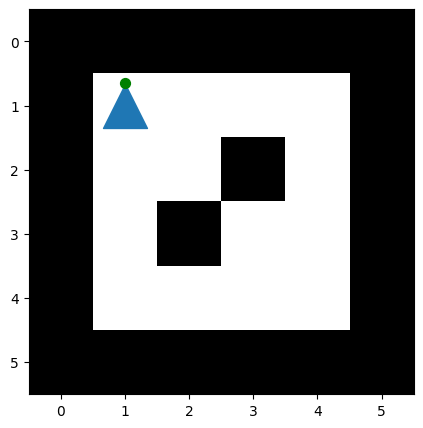

In [4]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []
env_test.display_world()

In [5]:
list_vocab = ['<pad>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    list_vocab.append(act)
for fb in env_test.get_outcomes():
    list_vocab.append(fb)

for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

<pad>
forward
turn_left
turn_right
feel_front
feel_left
feel_right
wall
empty
{'<pad>': 0, 'forward': 1, 'turn_left': 2, 'turn_right': 3, 'feel_front': 4, 'feel_left': 5, 'feel_right': 6, 'wall': 7, 'empty': 8}


# X and Y

## Chaque séquence est complétement indépendante
### Res :
Spoil : au moins a partir de 500, > 95% d'acc (50 epoch)

In [6]:
data_brut_y=[]
for i in range(1000):
    data_brut_y.append(get_data(env_test, tokenizer, n_episodes=50))

data_y = torch.tensor(data_brut_y)
data_loader = DataLoader(data_y, batch_size=16, shuffle=True)


## Une grande séquence découper

In [7]:
data_brut = get_data(env_test, tokenizer, n_episodes=1000)
print(data_brut)
def decoup_seq(seq:list, size:int, overlap:int=1):
    """
    Decoupe une sequence en sous-sequence de taille size
    """
    return [seq[i:i+size] for i in range(0, len(seq) - size +1, overlap)]

data_decoup = decoup_seq(seq=data_brut, size=30, overlap=10)
print(data_decoup)
data_decoup = torch.tensor(data_decoup)
data_loader_decoup = DataLoader(data_decoup, batch_size=16, shuffle=True)

[3, 8, 4, 7, 1, 7, 6, 8, 2, 8, 3, 8, 2, 8, 6, 7, 2, 8, 4, 8, 5, 8, 4, 8, 2, 8, 3, 8, 2, 8, 6, 8, 6, 8, 4, 8, 6, 8, 4, 8, 3, 8, 5, 8, 5, 8, 5, 8, 4, 8, 4, 8, 5, 8, 5, 8, 5, 8, 3, 8, 2, 8, 1, 8, 6, 7, 6, 7, 2, 8, 5, 8, 4, 7, 3, 8, 6, 7, 5, 7, 6, 7, 6, 7, 4, 8, 2, 8, 1, 7, 3, 8, 4, 8, 3, 8, 2, 8, 3, 8, 5, 8, 4, 7, 1, 7, 4, 7, 3, 8, 4, 8, 2, 8, 5, 8, 1, 7, 2, 8, 6, 7, 1, 8, 1, 8, 5, 8, 1, 7, 6, 7, 5, 8, 3, 8, 2, 8, 4, 7, 2, 8, 4, 8, 3, 8, 2, 8, 6, 7, 3, 8, 5, 8, 2, 8, 6, 7, 1, 8, 6, 7, 4, 8, 5, 8, 3, 8, 3, 8, 4, 8, 6, 8, 6, 8, 3, 8, 3, 8, 3, 8, 6, 8, 3, 8, 5, 7, 3, 8, 3, 8, 5, 8, 1, 8, 6, 7, 4, 8, 2, 8, 5, 8, 6, 8, 5, 8, 5, 8, 1, 7, 3, 8, 4, 8, 1, 8, 6, 7, 1, 7, 2, 8, 4, 8, 5, 8, 4, 8, 1, 8, 6, 7, 3, 8, 5, 8, 3, 8, 6, 7, 5, 7, 4, 8, 1, 8, 2, 8, 1, 7, 1, 7, 2, 8, 4, 8, 1, 8, 4, 8, 2, 8, 6, 8, 2, 8, 6, 7, 3, 8, 1, 7, 5, 8, 5, 8, 3, 8, 4, 8, 4, 8, 1, 8, 3, 8, 5, 8, 6, 8, 3, 8, 2, 8, 3, 8, 6, 8, 3, 8, 2, 8, 1, 8, 4, 8, 2, 8, 1, 7, 5, 8, 4, 7, 1, 7, 1, 7, 5, 8, 3, 8, 5, 7, 2, 8, 5, 8, 1, 7, 2, 

data_y est alors notre Y. Pour obtenir notre X, nous utiliserons un token Dropen

In [8]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

Notre x est donc data_x. Maintenant nous voulons que notre model arrive à obvenir un représentation de la séquence pour réussir a compléter les 0.

# Multi tasks ?
On peut vouloir un encoder qui apprend a encoder pour deviner les actions, et un encoder qui apprends a deviner les observations.


In [9]:
class TokenDropEven(nn.Module):
    """For a batch of tokens indices, randomly replace a non-special token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        super().__init__()
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        """Mask only action (even if it is not a special token) for a batch of samples."""
        sample_out = torch.empty_like(sample)
        for i, single_sample in enumerate(sample):
            even_sample = single_sample[::2]
            odd_sample = single_sample[1::2]
            
            # Generate mask for even elements
            mask = torch.bernoulli(self.prob * torch.ones_like(even_sample)).long()
            can_drop = (even_sample >= self.num_special).long()
            mask = mask * can_drop
            
            # Replace masked elements with <pad>
            replace_with = (self.pad_token * torch.ones_like(even_sample)).long()
            even_sample_out = (1 - mask) * even_sample + mask * replace_with
            
            # Recombine even and odd elements
            sample_out[i, ::2] = even_sample_out
            sample_out[i, 1::2] = odd_sample
        
        return sample_out

In [10]:
td = TokenDropEven(0.9, pad_token=0, num_special=2)
data_x = td(data_y)
print("data_x", data_x)
print("data_y", data_y)

data_x tensor([[0, 7, 1,  ..., 8, 3, 8],
        [0, 7, 0,  ..., 7, 1, 8],
        [0, 7, 1,  ..., 8, 2, 8],
        ...,
        [0, 8, 0,  ..., 7, 0, 8],
        [0, 7, 0,  ..., 8, 0, 8],
        [0, 8, 0,  ..., 8, 1, 8]])
data_y tensor([[4, 7, 1,  ..., 8, 3, 8],
        [6, 7, 4,  ..., 7, 1, 8],
        [5, 7, 1,  ..., 8, 2, 8],
        ...,
        [5, 8, 5,  ..., 7, 2, 8],
        [4, 7, 6,  ..., 8, 3, 8],
        [4, 8, 6,  ..., 8, 1, 8]])


In [11]:
class TokenDropOdd(nn.Module):
    """For a batch of tokens indices, randomly replace a non-special token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        super().__init__()
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        """Mask only action (even if it is not a special token) for a batch of samples."""
        sample_out = torch.empty_like(sample)
        for i, single_sample in enumerate(sample):
            even_sample = single_sample[::2]
            odd_sample = single_sample[1::2]
            
            # Generate mask for even elements
            mask = torch.bernoulli(self.prob * torch.ones_like(odd_sample)).long()
            can_drop = (odd_sample >= self.num_special).long()
            mask = mask * can_drop
            
            # Replace masked elements with <pad>
            replace_with = (self.pad_token * torch.ones_like(odd_sample)).long()
            old_sample_out = (1 - mask) * odd_sample + mask * replace_with
            
            # Recombine even and odd elements
            sample_out[i, ::2] = even_sample 
            sample_out[i, 1::2] = old_sample_out
        
        return sample_out

In [12]:
td = TokenDropOdd(0.9, pad_token=0, num_special=2)
data_x = td(data_y)
print("data_x", data_x)
print("data_y", data_y)

data_x tensor([[4, 0, 1,  ..., 0, 3, 0],
        [6, 7, 4,  ..., 0, 1, 0],
        [5, 0, 1,  ..., 0, 2, 0],
        ...,
        [5, 0, 5,  ..., 0, 2, 0],
        [4, 0, 6,  ..., 0, 3, 0],
        [4, 0, 6,  ..., 0, 1, 0]])
data_y tensor([[4, 7, 1,  ..., 8, 3, 8],
        [6, 7, 4,  ..., 7, 1, 8],
        [5, 7, 1,  ..., 8, 2, 8],
        ...,
        [5, 8, 5,  ..., 7, 2, 8],
        [4, 7, 6,  ..., 8, 3, 8],
        [4, 8, 6,  ..., 8, 1, 8]])


In [13]:
class CustomDataSet(Dataset):
    def __init__(self, data:list[list]):
        self.data = torch.tensor(data)
        print(self.data)

    def __len__(self):
        return self.data.size()[1]

    def __getitem__(self, idx):
        return self.data[idx]

In [14]:
data_set = CustomDataSet(data_brut_y)

print("len data_set", data_set.__len__())
print("data_set 1", data_set[0])

tensor([[4, 7, 1,  ..., 8, 3, 8],
        [6, 7, 4,  ..., 7, 1, 8],
        [5, 7, 1,  ..., 8, 2, 8],
        ...,
        [5, 8, 5,  ..., 7, 2, 8],
        [4, 7, 6,  ..., 8, 3, 8],
        [4, 8, 6,  ..., 8, 1, 8]])
len data_set 100
data_set 1 tensor([4, 7, 1, 7, 2, 8, 6, 7, 1, 7, 3, 8, 2, 8, 6, 7, 2, 8, 2, 8, 4, 8, 3, 8,
        2, 8, 3, 8, 3, 8, 1, 7, 2, 8, 4, 8, 5, 8, 5, 8, 1, 8, 1, 8, 6, 7, 2, 8,
        3, 8, 5, 7, 2, 8, 6, 8, 5, 8, 3, 8, 4, 8, 6, 7, 4, 8, 5, 7, 1, 8, 2, 8,
        5, 8, 5, 8, 2, 8, 2, 8, 1, 7, 4, 7, 5, 7, 5, 7, 5, 7, 5, 7, 6, 8, 3, 8,
        6, 8, 3, 8])


In [15]:
def train(model: nn.Module, data_loader_train: DataLoader, nb_epoch: int, optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td_act = TokenDropEven(pourcentTokenDrop, pad_token=0, num_special=2).to(device)
    td_fb = TokenDropOdd(pourcentTokenDrop, pad_token=0, num_special=2).to(device)

    model.train()
    acc = 0
    total_loss = 0
    list_acc = []
    list_loss = []
    for j in tqdm(range(nb_epoch), desc=f"Training ", unit="epoch"):
        acc_means = [0, 0]
        loss_means = [0, 0]
        
        for i, data in enumerate(data_loader_train):
            data = data.to(device)
            data_mask_act = td_act(data)
            data_mask_fb = td_fb(data)
            bs = data.shape[0]
            # print("batch size ", bs)

            # Initialize the memory buffers
            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size, device=device)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size, device=device)
            # print(f'shape hidden and memory {hidden.shape} | {memory.shape}')
            total_loss = 0  # Accumulate loss over both tasks

            for k, tasks in enumerate([data_mask_act, data_mask_fb]):
                # Forward pass
                tasks = tasks.to(device)
                proba, hidden, memory = model(tasks, hidden, memory)
                proba = proba.transpose(1, 2)
                pred = proba.argmax(dim=1)
                # if j == nb_epoch - 1:
                #     print("tasks : ", tasks)
                #     print("prediction : ", pred)
                #     print("goal : ", data)
                #     print("loss", loss)
                pad_mask = (tasks == 0)
                correct = (pred == data) & pad_mask
                acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
                acc_means[k] += acc
                
                loss = loss_fn(proba, data)  # Use proba instead of pred
                total_loss += loss  # Accumulate loss
                loss_means[k] += loss.item()
                
            # print("total_loss", total_loss)
            # Backward pass and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
        acc_means = [acc / len(data_loader_train) for acc in acc_means]
        loss_means = [loss / len(data_loader_train) for loss in loss_means]
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {j + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")
        
    return list_acc, list_loss
        
def train_fb(model: nn.Module, data_loader_train: DataLoader, nb_epoch: int, optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td_fb = TokenDropOdd(pourcentTokenDrop, pad_token=0, num_special=2).to(device)

    model.train()
    list_acc = []
    list_loss = []
    for j in trange(nb_epoch, desc=f"Training ", unit="epoch"):
        acc_means = 0
        loss_means = 0
        
        for i, data in enumerate(data_loader_train):
            data = data.to(device)
            data_mask_fb = td_fb(data).to(device)
            bs = data.shape[0]
            # print("batch size ", bs)

            # Initialize the memory buffers
            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size, device=device)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size, device=device)
            # print(f'shape hidden and memory {hidden.shape} | {memory.shape}')
                        
            proba, hidden, memory = model(data_mask_fb, hidden, memory)
            proba = proba.transpose(1, 2)
            pred = proba.argmax(dim=1)
            pad_mask = (data_mask_fb == 0)
 
            correct = (pred == data) & pad_mask
            acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
            acc_means += acc
        
            loss = loss_fn(proba, data) 
            loss_means += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        acc_means /= len(data_loader_train)
        loss_means /= len(data_loader_train)
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {j + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")
    return list_acc, list_loss

In [16]:
num_layers = 1
hidden_size = 128
temp = 1.0
model = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.1
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [17]:
# train(
#     model=model,
#     data_loader_train=data_loader,
#     nb_epoch=100,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     pourcentTokenDrop=0.15
# )

In [18]:
num_layers = 2
hidden_size = 256
model_fb = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0
).to(device)
# 32 = 95 % | plus de 32 = 95 %
# 16 < 90 %
optimizer_fb = optim.Adam(model_fb.parameters(), lr=0.001)
loss_fn_fb = nn.CrossEntropyLoss()

list_acc, list_loss = train_fb(
    model=model_fb,
    data_loader_train=data_loader,
    nb_epoch=50,
    optimizer=optimizer_fb,
    loss_fn=loss_fn_fb,
    pourcentTokenDrop=0.15
)


Training :   0%|          | 0/50 [00:00<?, ?epoch/s]

Epoch 1/50, Loss: 0.17017339545464705, Accuracy: 0.6395139410090456
Epoch 2/50, Loss: 0.03540696188925751, Accuracy: 0.7180340102720799
Epoch 3/50, Loss: 0.03344010996321837, Accuracy: 0.7358354026740244
Epoch 4/50, Loss: 0.03290426465017455, Accuracy: 0.7443611579082717
Epoch 5/50, Loss: 0.029984979077227532, Accuracy: 0.7747440274115205
Epoch 6/50, Loss: 0.027067492937757856, Accuracy: 0.8038158586610268
Epoch 7/50, Loss: 0.023881727489568884, Accuracy: 0.8253203585827503
Epoch 8/50, Loss: 0.022242361324883643, Accuracy: 0.8411379719037514
Epoch 9/50, Loss: 0.019711600941798045, Accuracy: 0.8653514795053918
Epoch 10/50, Loss: 0.017795083290409474, Accuracy: 0.8789687370811358
Epoch 11/50, Loss: 0.017476768011138552, Accuracy: 0.8889463671467493
Epoch 12/50, Loss: 0.016291587170036065, Accuracy: 0.8971982071893081
Epoch 13/50, Loss: 0.01606138881355051, Accuracy: 0.895457137176856
Epoch 14/50, Loss: 0.014371611074441008, Accuracy: 0.9056193407270464
Epoch 15/50, Loss: 0.01400000706965

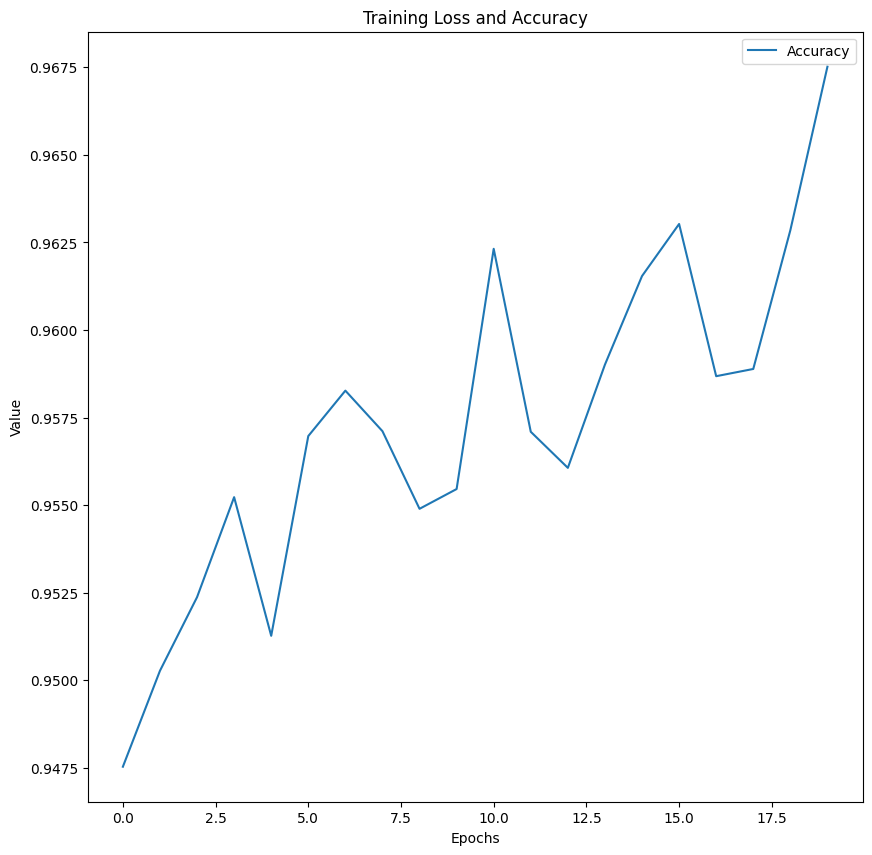

In [19]:
# Plot
plt.figure(figsize=(10, 10))
# plt.plot(list_loss, label='Loss')
plt.plot(list_acc[-20:], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

Training :   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 1/100, Loss: 0.7426896513654635, Accuracy: 0.45958772011540877
Epoch 2/100, Loss: 0.05400476246499098, Accuracy: 0.653010322177532
Epoch 3/100, Loss: 0.032707479424201526, Accuracy: 0.6605499867697389
Epoch 4/100, Loss: 0.02929559923135317, Accuracy: 0.6775560346925682
Epoch 5/100, Loss: 0.030381789717536706, Accuracy: 0.6876557357623045
Epoch 6/100, Loss: 0.029087514544908818, Accuracy: 0.6956935389062084
Epoch 7/100, Loss: 0.02354918334346551, Accuracy: 0.751368035104112
Epoch 8/100, Loss: 0.026680061163810585, Accuracy: 0.696492784524705
Epoch 9/100, Loss: 0.023950392810197976, Accuracy: 0.7078292873228453
Epoch 10/100, Loss: 0.023631647659035828, Accuracy: 0.7323804104309903
Epoch 11/100, Loss: 0.02530774574440259, Accuracy: 0.6870287194168085
Epoch 12/100, Loss: 0.022077582848186676, Accuracy: 0.7560646401783526
Epoch 13/100, Loss: 0.023920031980826303, Accuracy: 0.7365254516064235
Epoch 14/100, Loss: 0.02333305238817747, Accuracy: 0.7231242931118107
Epoch 15/100, Loss: 0.02

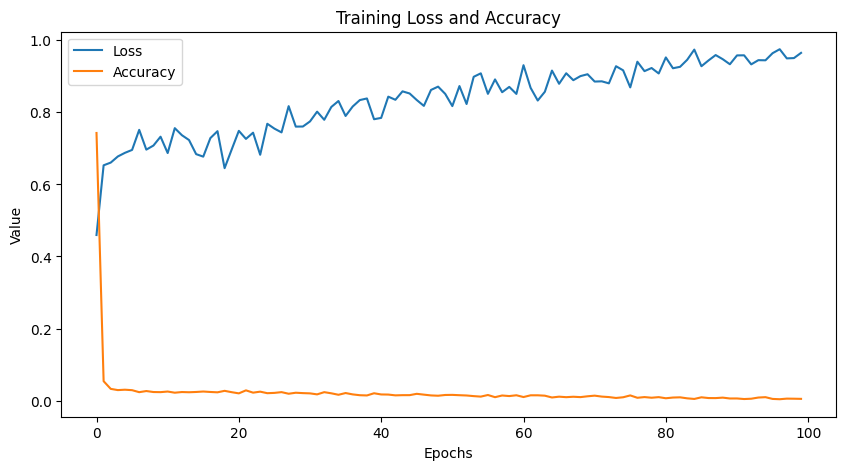

In [20]:
model_fb_decoup = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=256,
    emb_size=256,
    num_layers=2,
    dropout=0
).to(device)

optimizer_fb_decoup = optim.Adam(model_fb_decoup.parameters(), lr=0.001)
loss_fn_fb_decoup = nn.CrossEntropyLoss()

list_loss, list_acc = train_fb(
    model=model_fb_decoup,
    data_loader_train=data_loader_decoup,
    nb_epoch=100,
    optimizer=optimizer_fb_decoup,
    loss_fn=loss_fn_fb_decoup,
    pourcentTokenDrop=0.1
)
# Plot
plt.figure(figsize=(10, 5))
plt.plot(list_loss, label='Loss')
plt.plot(list_acc, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

In [21]:
env_test_manu = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

action = []
outcome = []
all_seq = []
list_act_to_make = ['turn_right', 'forward', 'turn_left', 'forward', 'feel_right']

for act in list_act_to_make:
    action.append(act)
    outcome.append(env_test_manu.outcome(action[-1]))
    env_test_manu.save_world(path='imgToGif')
    all_seq += tokenizer.encode([action[-1], outcome[-1]])

print("Action : ", action)
print("Outcome : ", outcome)
print("all_seq : ", all_seq)

# We add one action exemple feel left


The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
Action :  ['turn_right', 'forward', 'turn_left', 'forward', 'feel_right']
Outcome :  ['empty', 'empty', 'empty', 'wall', 'empty']
all_seq :  [3, 8, 1, 8, 2, 8, 1, 7, 6, 8]


In [22]:
prompt = all_seq.copy()
prompt += tokenizer.encode(['feel_right', "<pad>"])

hidden = torch.zeros(2 * model.num_layers, 1, model.hidden_size)
memory = torch.zeros(2 * model.num_layers, 1, model.hidden_size)

prompt = torch.tensor(prompt)
prompt = prompt.unsqueeze(0)
proba, hidden, memory = model(prompt, hidden, memory)
print('hidden', hidden)
print('memory', memory)

proba = proba.transpose(1, 2)
pred = proba.argmax(dim=1)
print("proba", proba)
print("prediction", pred)
print(tokenizer.decode(pred[0].tolist()))
print(tokenizer.decode(prompt[0].tolist()))

hidden tensor([[[ 1.0180e-01,  1.2090e-01, -1.8745e-01,  1.6451e-01, -7.0648e-02,
          -1.0734e-01,  9.1260e-02,  2.5078e-01, -3.9765e-02, -3.5277e-01,
           9.4016e-02,  7.0144e-02, -2.1698e-01, -1.6106e-01, -3.1813e-01,
           2.0704e-01,  6.2215e-02,  2.1299e-01,  8.7410e-02,  1.0669e-02,
           2.7891e-02,  3.7565e-01, -1.8258e-01,  1.1490e-02, -2.1188e-01,
           8.1080e-02,  7.6808e-02, -2.8212e-01,  2.9303e-01, -6.6383e-02,
           1.3745e-01, -1.7032e-01,  1.8796e-01,  7.8449e-03, -2.0780e-01,
          -2.1181e-01, -7.4646e-02, -4.2502e-03,  1.5362e-02, -8.4456e-02,
          -1.6786e-02, -2.1718e-01, -2.6890e-02, -5.5010e-02,  1.2176e-01,
           3.3600e-01, -1.7314e-01,  7.2571e-02, -5.3557e-02, -1.1475e-01,
          -6.3969e-02, -3.3045e-02, -1.2625e-01, -5.4318e-02,  2.6031e-01,
          -1.7142e-01,  2.1546e-01, -8.5647e-02,  6.6629e-02, -2.0185e-01,
          -4.5690e-02,  2.5242e-01,  3.2430e-01, -2.3431e-01, -9.4723e-03,
          -1.1322e

In [23]:
env_test_manu = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

action = []
outcome = []
all_seq = []
list_act_to_make = ['turn_right', 'forward', 'forward', 'forward', 'turn_left', 'turn_left', 'forward', 'feel_right', 'turn_right', 'feel_left']

for act in list_act_to_make:
    action.append(act)
    outcome.append(env_test_manu.outcome(action[-1]))
    env_test_manu.save_world(path='imgToGif2')
    all_seq += tokenizer.encode([action[-1], outcome[-1]])

print("Action : ", action)
print("Outcome : ", outcome)
print("all_seq : ", all_seq)

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
Action :  ['turn_right', 'forward', 'forward', 'forward', 'turn_left', 'turn_left', 'forward', 'feel_right', 'turn_right', 'feel_left']
Outcome :  ['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'wall', 'empty', 'empty']
all_seq :  [3, 8, 1, 8, 1, 8, 1, 8, 2, 8, 2, 8, 1, 8, 6, 7, 3, 8, 5, 8]


In [24]:
# We add one action exemple feel left
prompt = all_seq.copy()
prompt += tokenizer.encode(["feel_front", "<pad>"])
prompt = prompt[-10:]
print('prompt ', prompt)

hidden = torch.zeros(2 * model.num_layers, 1, model.hidden_size)
memory = torch.zeros(2 * model.num_layers, 1, model.hidden_size)

prompt_tensor = torch.tensor(prompt)
prompt_tensor = prompt_tensor.unsqueeze(0)
proba, hidden, memory = model(prompt_tensor, hidden, memory)

proba = proba.transpose(1, 2)
pred = proba.argmax(dim=1)
print("proba", proba)
print("prediction", pred)
print(tokenizer.decode(pred[0].tolist()))
print(tokenizer.decode(prompt_tensor[0].tolist()))

print('hidden', hidden)
print('memory', memory)

prompt  [1, 8, 6, 7, 3, 8, 5, 8, 4, 0]
proba tensor([[[-0.2114, -0.4319, -0.6890, -0.3026, -0.1234, -0.2923,  0.2107,
           0.4084,  0.6681,  0.0167],
         [ 0.0976, -0.4460, -0.3553, -0.1201,  0.0567, -0.2751,  0.0560,
          -0.3602,  0.0101,  0.6071],
         [ 0.6924, -0.0308, -0.2148,  0.0230,  0.4318,  0.4020,  0.2550,
           0.5597, -0.0091, -0.3392],
         [-0.3622, -0.0459,  0.0300, -0.0178, -0.1104, -0.4511, -0.1528,
          -0.0438, -0.4553,  0.0828],
         [-0.5725, -0.0384, -0.7711, -0.1239, -0.5784, -0.2248, -0.0403,
          -0.3795, -0.1502, -0.6025],
         [-0.4848, -1.0969, -1.1751, -0.8419, -0.6617, -0.7762, -0.9511,
          -1.1097, -0.9165, -0.1767],
         [ 0.0263, -0.5074, -0.6155, -0.6527,  0.0967, -0.4805, -0.0044,
          -0.6657, -0.4641, -0.5704],
         [ 0.2410, -0.1688, -0.2822, -0.2789,  0.3914,  0.2157, -0.1511,
          -0.1507, -0.5083, -0.7277],
         [ 0.4327,  0.2994, -0.0417, -0.1361, -0.1033,  0.0332,  0.

In [25]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

data_test_x = []
data_test_y = []
data_infos = []
for i in range(10000):
    # range_context = np.random.randint(10, 20)
    range_context = 30
    last_act = "turn_left"
    while last_act == "turn_left" or last_act == "turn_right":
        sequence = get_data(env_test, tokenizer, n_episodes=range_context)
        last_act = tokenizer.decode(sequence[-2])
            
    data_test_x.append(sequence[:-1] + [0])    
    data_test_y.append(sequence[-1])
    
    data_infos.append({
        "sequence": tokenizer.decode(sequence),
        "coo": env_test.get_coo(),
        "theta": env_test.get_theta(),
        "last_act": last_act,
        "last_feedback": tokenizer.decode(sequence[-1]),
        "info_in_sequence": bool(info_in_seq(tokenizer.decode(data_test_x[-1]), 6))
    })
    around = ''
    for feel in ["feel_front", "feel_left", "feel_right"]:
        state = env_test.outcome(feel)
        data_infos[-1][feel] = state
        around += f"{state}|"
    
# print("data_test_x", data_test_x)
# print("data_test_y", data_test_y)

# count 9 and 8 in data_test_y
count_7 = 0
count_8 = 0

for i in data_test_y:
    if i == 8:
        count_8 += 1
    elif i == 7:
        count_7 += 1
print(f"count_8 {tokenizer.decode(8)}", count_8)
print(f"count_7 {tokenizer.decode(7)}", count_7)

print("data_infos", data_infos[0])
print("x ", data_test_x[0])
print("y ", data_test_y[0])

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
count_8 empty 5137
count_7 wall 4863
data_infos {'sequence': ['turn_left', 'empty', 'turn_left', 'empty', 'feel_front', 'empty', 'feel_front', 'empty', 'turn_left', 'empty', 'feel_front', 'empty', 'forward', 'empty', 'forward', 'empty', 'feel_left', 'wall', 'feel_left', 'wall', 'forward', 'empty', 'turn_left', 'empty', 'feel_right', 'wall', 'feel_right', 'wall', 'turn_left', 'empty', 'feel_left', 'empty', 'feel_right', 'wall', 'forward', 'empty', 'feel_front', 'empty', 'feel_left', 'empty', 'turn_right', 'empty', 'feel_left', 'empty', 'feel_front', 'wall', 'turn_left', 'empty', 'turn_left', 'empty', 'turn_right', 'empty', 'turn_left', 'empty', 'feel_left', 'empty', 'turn_left', 'empty', 'feel_right', 'empty'], 'coo': (1, 2), 'theta': 0, 'last_act': 'feel_right', 'last_feedback': 'empty', 'info_in_sequence': True, 'feel_front': 'empty', 'feel_left': 'wall', '

In [26]:
for key, value in data_infos[56].items():
    print(f"{key}: {value}")


sequence: ['feel_right', 'empty', 'turn_left', 'empty', 'feel_left', 'wall', 'feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty', 'turn_left', 'empty', 'feel_right', 'empty', 'turn_left', 'empty', 'turn_left', 'empty', 'feel_front', 'wall', 'feel_right', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'turn_right', 'empty', 'feel_right', 'empty', 'turn_left', 'empty', 'turn_left', 'empty', 'feel_front', 'empty', 'turn_left', 'empty', 'feel_left', 'wall', 'feel_left', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'forward', 'wall', 'feel_front', 'wall', 'turn_left', 'empty', 'turn_right', 'empty', 'forward', 'wall']
coo: (4, 1)
theta: 0
last_act: forward
last_feedback: wall
info_in_sequence: True
feel_front: wall
feel_left: empty
feel_right: wall


In [27]:
length = max(map(len, data_test_x))
data_test_x_array=np.array([xi+[0]*(length-len(xi)) for xi in data_test_x])
data_test_x_array = np.array(data_test_x_array)
data_test_x_tensor = torch.from_numpy(data_test_x_array)
data_test_x_tensor = torch.tensor(data_test_x_tensor)
data_test_x_tensor = data_test_x_tensor.squeeze()
data_test_y_tensor = torch.tensor(data_test_y)

print("data_test_x", data_test_x_tensor)
print("data_test_y", data_test_y_tensor)
print("data_test_x_tensor shape", data_test_x_tensor.shape)
print("data_test_y_tensor shape", data_test_y_tensor.shape)

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target

data_loader_test = DataLoader(CustomDataset(data_test_x_tensor, data_test_y_tensor), batch_size=1, shuffle=True)

for i, (data_x, data_y) in enumerate(data_loader_test):
    print(data_x)
    print(data_y)
    break

data_test_x tensor([[2, 8, 2,  ..., 8, 6, 0],
        [2, 8, 4,  ..., 7, 6, 0],
        [5, 8, 5,  ..., 8, 5, 0],
        ...,
        [3, 8, 6,  ..., 8, 5, 0],
        [4, 8, 5,  ..., 8, 5, 0],
        [3, 8, 2,  ..., 8, 4, 0]])
data_test_y tensor([8, 8, 8,  ..., 7, 7, 8])
data_test_x_tensor shape torch.Size([10000, 60])
data_test_y_tensor shape torch.Size([10000])
tensor([[1, 7, 3, 8, 4, 8, 1, 8, 4, 8, 5, 7, 3, 8, 1, 8, 3, 8, 4, 7, 1, 7, 4, 7,
         5, 7, 6, 8, 3, 8, 4, 8, 6, 8, 3, 8, 5, 8, 4, 8, 5, 8, 6, 7, 3, 8, 5, 8,
         1, 7, 1, 7, 4, 7, 6, 7, 4, 7, 5, 0]])
tensor([8])


/tmp/ipykernel_15801/4196987009.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_test_x_tensor = torch.tensor(data_test_x_tensor)


In [28]:
# # Test the model
# model.eval()
# acc = 0

# with torch.no_grad():
#     for (x, y) in data_loader_test:
        
#         h = torch.zeros(model.num_layers * 2, 1, model.hidden_size)
#         cell = torch.zeros(model.num_layers * 2, 1, model.hidden_size)
        
#         # Forward pass
#         output, h, cell = model(x, h, cell)
#         output = output.transpose(1, 2)
#         pred = output.argmax(dim=1)

#         acc += (pred[-1][-1] == y).sum().item()
        
# print(f"Accuracy: {acc / 10000}")

In [29]:
model_fb.eval()
acc = 0

data_frame_seq = pd.DataFrame(np.empty((len(data_loader_test), 6)), 
                            columns=["seq", "prediction", "reality", "probability", "info_in_seq",  "good_prediction"])
data_frame_seq = data_frame_seq.astype({"seq" : "U20", "prediction" : "U20", "reality": "U20",  "probability": "U20",  "info_in_seq" : bool,  "good_prediction": bool})


data_frame_seq_decode = pd.DataFrame(np.empty((len(data_loader_test), 6)), 
                            columns=["seq", "prediction", "reality", "probability", "info_in_seq", "good_prediction"])
data_frame_seq_decode = data_frame_seq_decode.astype({"seq" : "U20", "prediction" : "U20", "reality": "U20",  "probability": "U20",  "info_in_seq" : bool,  "good_prediction": bool})

with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(data_loader_test)):
        x = x.to(device)
        y = y.to(device)
        h = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
        cell = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
        good_seq = info_in_seq(tokenizer.decode(x.tolist()[0]), 6)
        
        # Forward pass
        output, h, cell = model_fb(x, h, cell)
        proba = F.softmax(output, dim=-1)
        output = output.transpose(1, 2)
        pred = output.argmax(dim=1)
        acc += (pred[-1][-1] == y).item()
        data_frame_seq.iloc[i, 0] = str(x.tolist()[0])
        data_frame_seq.iloc[i, 1] = str(pred.tolist()[0])
        data_frame_seq.iloc[i, 2] = y.tolist()
        data_frame_seq.iloc[i, 3] = str(proba.tolist()[-1] [-1] [-2:])
        data_frame_seq.iloc[i, 4] = good_seq
        data_frame_seq.iloc[i, -1] = (pred[-1][-1] == y).item()
        
        data_frame_seq_decode.iloc[i, 0] = str(tokenizer.decode(x.tolist()[0]))
        data_frame_seq_decode.iloc[i, 1] = str(tokenizer.decode(pred.tolist()[0]))
        data_frame_seq_decode.iloc[i, 2] = tokenizer.decode(y.tolist())[0]
        data_frame_seq_decode.iloc[i, 3] = str(proba.tolist()[-1] [-1] [-2:])
        data_frame_seq_decode.iloc[i, 4] = good_seq
        data_frame_seq_decode.iloc[i, -1] = (pred[-1][-1] == y).item()
        
print(f"Accuracy: {acc / 10000}")

0it [00:00, ?it/s]

Accuracy: 0.9094


In [30]:
model_fb_decoup.eval()
acc = 0

data_frame_seq_2 = pd.DataFrame(np.empty((len(data_loader_test), 6)), 
                            columns=["seq", "prediction", "reality", "probability", "info_in_seq",  "good_prediction"])
data_frame_seq_2 = data_frame_seq_2.astype({"seq" : "U20", "prediction" : "U20", "reality": "U20",  "probability": "U20",  "info_in_seq" : "bool",  "good_prediction": "bool"})


data_frame_seq_decode_2 = pd.DataFrame(np.empty((len(data_loader_test), 6)), 
                            columns=["seq", "prediction", "reality", "probability", "info_in_seq", "good_prediction"])
data_frame_seq_decode_2 = data_frame_seq_decode_2.astype({"seq" : "U20", "prediction" : "U20", "reality": "U20",  "probability": "U20",  "info_in_seq" : "bool",  "good_prediction": "bool"})

with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(data_loader_test)):
        x = x.to(device)
        y = y.to(device)
        h = torch.zeros(model_fb_decoup.num_layers * 2, 1, model_fb_decoup.hidden_size).to(device)
        cell = torch.zeros(model_fb_decoup.num_layers * 2, 1, model_fb_decoup.hidden_size).to(device)
        good_seq = info_in_seq(tokenizer.decode(x.tolist()[0]), 6)
        
        # Forward pass
        output, h, cell = model_fb_decoup(x, h, cell)
        proba = F.softmax(output, dim=-1)
        output = output.transpose(1, 2)
        pred = output.argmax(dim=1)
        acc += (pred[-1][-1] == y).item()
        data_frame_seq_2.iloc[i, 0] = str(x.tolist()[0])
        data_frame_seq_2.iloc[i, 1] = str(pred.tolist()[0])
        data_frame_seq_2.iloc[i, 2] = y.tolist()
        data_frame_seq_2.iloc[i, 3] = str(proba.tolist()[-1] [-1] [-2:])
        data_frame_seq_2.iloc[i, 4] = bool(good_seq)
        data_frame_seq_2.iloc[i, -1] = (pred[-1][-1] == y).item()
        
        data_frame_seq_decode_2.iloc[i, 0] = str(tokenizer.decode(x.tolist()[0]))
        data_frame_seq_decode_2.iloc[i, 1] = str(tokenizer.decode(pred.tolist()[0]))
        data_frame_seq_decode_2.iloc[i, 2] = tokenizer.decode(y.tolist())[0]
        data_frame_seq_decode_2.iloc[i, 3] = str(proba.tolist()[-1] [-1] [-2:])
        data_frame_seq_decode_2.iloc[i, 4] = bool(good_seq)
        data_frame_seq_decode_2.iloc[i, -1] = (pred[-1][-1] == y).item()
        
        
print(f"Accuracy: {acc / 10000}")

/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:133: RuntimeWarning: invalid value encountered in cast
  return arr.astype(dtype, copy=True)
/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:133: RuntimeWarning: invalid value encountered in cast
  return arr.astype(dtype, copy=True)
/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:133: RuntimeWarning: invalid value encountered in cast
  return arr.astype(dtype, copy=True)
/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:133: RuntimeWarning: invalid value encountered in cast
  return arr.astype(dtype, copy=True)


0it [00:00, ?it/s]

Accuracy: 0.7178


# Résultat

0.96 % d'accuracy  

data test est constituer de 82% sequence dont l'information/feedback demandé a été vue  

Sur la partie où l’information n'est pas dans la séquence, l'accuracy tombe à 83%  

Sur la partie où l’information est dans la séquence, l'accuracy monte à 99%

## Not same environment
Quand il n'y a pas le même environment (autre grille) entre le train et le teste, 
acc = 83%
  
Si nous prenons que les seq avec infos alors on passe à 97% 

## Big context
0.97 % 
92% on une séquence avec une infos
sinon même stats

# analyse data train et data test


In [31]:
nb_repeat_test = 0

set_seq_test = set()
for i, (x, y) in enumerate(data_loader_test):
    seq = str(x.tolist()[0])
    if str(seq) in set_seq_test:
        nb_repeat_test += 1
    else:
        set_seq_test.add(str(seq))

print("nb_repeat", nb_repeat_test)
print("len set_seq", len(set_seq_test))
print(set_seq_test)

nb_repeat_train = 0

set_seq_train = set()
for i, x in enumerate(data_loader):
    seq = str(x.tolist())
    if str(seq) in set_seq_train:
        nb_repeat_train += 1
    else:
        set_seq_train.add(str(seq))

print("nb_repeat", nb_repeat_train)
print("len set_seq", len(set_seq_train))
print(set_seq_train)
    

nb_repeat 0
len set_seq 10000
{'[3, 8, 1, 7, 1, 7, 2, 8, 1, 7, 3, 8, 1, 7, 5, 7, 4, 7, 5, 7, 1, 7, 3, 8, 5, 7, 5, 7, 2, 8, 1, 7, 2, 8, 5, 8, 4, 7, 3, 8, 2, 8, 5, 8, 3, 8, 5, 7, 2, 8, 3, 8, 3, 8, 2, 8, 4, 7, 5, 0]', '[5, 7, 6, 7, 4, 8, 4, 8, 2, 8, 1, 7, 2, 8, 5, 7, 1, 8, 6, 8, 3, 8, 3, 8, 2, 8, 4, 8, 6, 8, 2, 8, 3, 8, 4, 8, 3, 8, 6, 7, 1, 8, 4, 8, 5, 7, 3, 8, 2, 8, 4, 8, 2, 8, 3, 8, 1, 8, 5, 0]', '[2, 8, 1, 8, 3, 8, 4, 7, 5, 7, 4, 7, 6, 8, 2, 8, 3, 8, 3, 8, 2, 8, 6, 8, 3, 8, 2, 8, 6, 8, 3, 8, 2, 8, 1, 7, 6, 8, 6, 8, 2, 8, 6, 7, 3, 8, 3, 8, 2, 8, 1, 7, 3, 8, 4, 8, 6, 8, 4, 0]', '[5, 7, 5, 7, 6, 7, 6, 7, 4, 8, 5, 7, 1, 8, 1, 8, 3, 8, 1, 7, 3, 8, 4, 8, 5, 7, 6, 8, 3, 8, 5, 8, 3, 8, 4, 7, 3, 8, 1, 7, 2, 8, 3, 8, 6, 8, 2, 8, 3, 8, 2, 8, 4, 7, 5, 8, 1, 7, 4, 0]', '[2, 8, 2, 8, 5, 7, 6, 7, 5, 7, 3, 8, 3, 8, 2, 8, 2, 8, 4, 8, 2, 8, 2, 8, 6, 7, 3, 8, 2, 8, 3, 8, 2, 8, 2, 8, 1, 7, 4, 7, 5, 8, 4, 7, 3, 8, 2, 8, 1, 7, 5, 8, 5, 8, 1, 7, 1, 7, 1, 0]', '[1, 8, 1, 8, 2, 8, 6, 7, 6, 7, 1, 7, 3, 8, 4, 7,

# Embeding

In [32]:
model_fb.eval()
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
print("hidden_in", hidden_in.shape)
print("mem_in", mem_in.shape)
all_hidden = []
all_mem = []
all_output_1 = []
all_output_2 = []

for x, y, info in zip(data_test_x, data_test_y, data_infos):
    input_seq = torch.tensor(x).to(device)
    output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))
    all_hidden.append(hidden_out[-1])
    all_mem.append(mem_out[-1])
    all_output_1.append(output[-1])
    all_output_2.append(output[29])


print("shape output", all_output_1[0].shape)

hidden_in torch.Size([4, 1, 256])
mem_in torch.Size([4, 1, 256])
shape output torch.Size([512])


all_hidden torch.Size([10000, 256])
all_mem torch.Size([10000, 256])
all_hidden (10000, 256)
all_mem (10000, 256)


/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_hidden_emb (10000, 2)
all_mem_emb (10000, 2)
coo_info ['(1, 2)', '(1, 2)', '(2, 1)', '(2, 1)', '(1, 3)', '(1, 4)', '(1, 4)', '(2, 2)', '(1, 1)', '(3, 1)', '(4, 4)', '(4, 3)', '(2, 4)', '(3, 3)', '(4, 2)', '(3, 1)', '(2, 2)', '(1, 2)', '(4, 1)', '(4, 2)', '(4, 4)', '(3, 4)', '(4, 1)', '(1, 1)', '(2, 1)', '(1, 3)', '(1, 4)', '(1, 1)', '(2, 1)', '(3, 4)', '(4, 2)', '(4, 4)', '(4, 4)', '(4, 4)', '(4, 4)', '(2, 4)', '(3, 4)', '(4, 4)', '(3, 4)', '(3, 3)', '(1, 4)', '(1, 3)', '(2, 2)', '(4, 1)', '(4, 1)', '(4, 2)', '(4, 1)', '(4, 1)', '(4, 1)', '(4, 1)', '(4, 2)', '(3, 3)', '(3, 3)', '(1, 2)', '(3, 1)', '(4, 1)', '(4, 1)', '(4, 4)', '(4, 3)', '(3, 3)', '(3, 3)', '(3, 3)', '(3, 3)', '(1, 3)', '(2, 4)', '(4, 2)', '(4, 2)', '(3, 4)', '(1, 2)', '(1, 4)', '(1, 4)', '(2, 2)', '(1, 4)', '(1, 2)', '(1, 1)', '(4, 1)', '(4, 4)', '(4, 4)', '(2, 4)', '(2, 2)', '(4, 3)', '(3, 3)', '(3, 3)', '(1, 4)', '(2, 4)', '(2, 4)', '(3, 3)', '(4, 3)', '(2, 4)', '(4, 4)', '(4, 2)', '(3, 1)', '(3, 4)', '(2, 4)', '

/tmp/ipykernel_15801/1297322004.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_coo))
/tmp/ipykernel_15801/1297322004.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_coo_theta))
/tmp/ipykernel_15801/1297322004.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=coo_colors, cmap='viridis', alpha=0.6)
/tmp/ipykernel_15801/1297322004.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

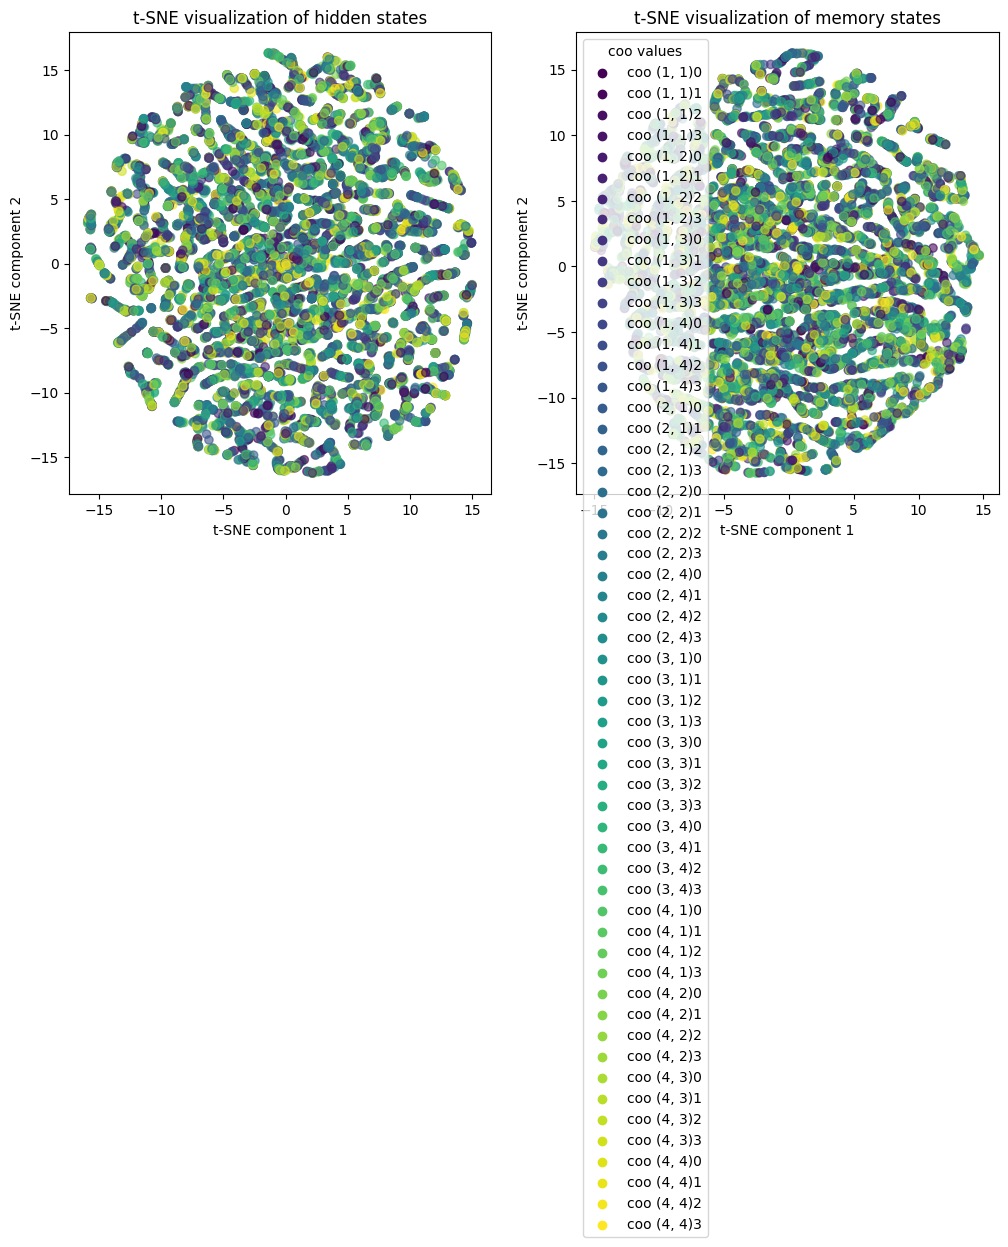

all_output_stack (10000, 512)


/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_output_emb (10000, 2)


/tmp/ipykernel_15801/1297322004.py:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=coo_colors, cmap='viridis', alpha=0.6)
/tmp/ipykernel_15801/1297322004.py:73: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


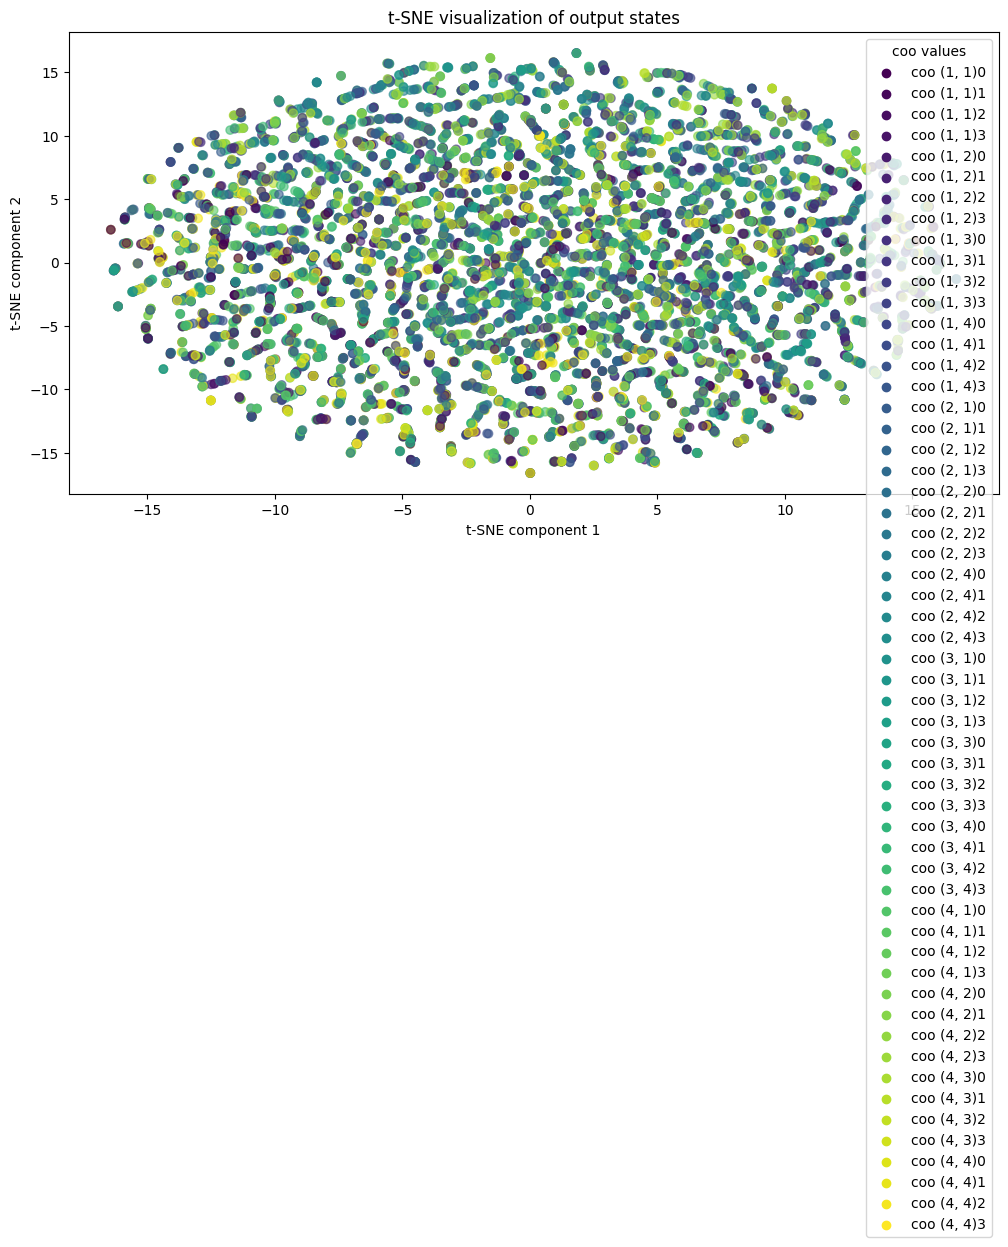

all_output_stack (10000, 512)


/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_output_emb (10000, 2)


/tmp/ipykernel_15801/1297322004.py:84: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=coo_colors, cmap='viridis', alpha=0.6)
/tmp/ipykernel_15801/1297322004.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


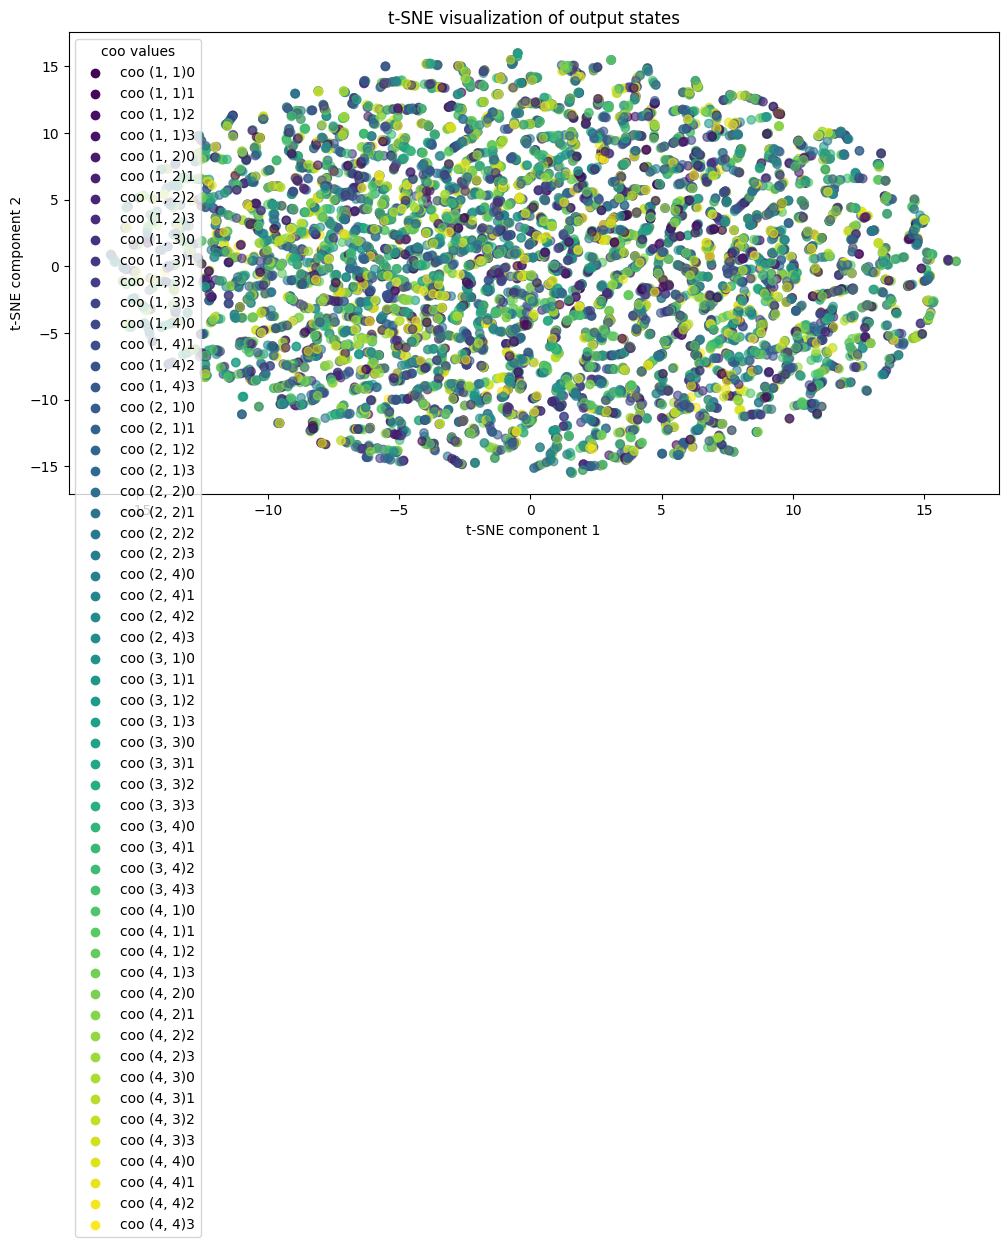

In [33]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)
print("all_hidden_emb", all_hidden_emb.shape)
print("all_mem_emb", all_mem_emb.shape)

coo_info = [str(info['coo']) for info in data_infos]

print("coo_info", coo_info)

unique_coo = np.unique(coo_info)
print("unique_coo", unique_coo)
color_map = plt.cm.get_cmap('viridis', len(unique_coo))
coo_colors = [color_map(unique_coo.tolist().index(str(coo))) for coo in coo_info]

coo_theta_info = [str(info['coo']) + str(info['theta']) for info in data_infos]

print("coo_info", coo_theta_info)

unique_coo_theta = np.unique(coo_theta_info)
print("unique_coo", unique_coo_theta)
color_map = plt.cm.get_cmap('viridis', len(unique_coo_theta))
coo_colors = [color_map(unique_coo_theta.tolist().index(str(coo))) for coo in coo_theta_info]

plt.figure(figsize=(12, 6))

# Plot pour all_hidden_emb
plt.subplot(1, 2, 1)
plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=coo_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of hidden states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# Plot pour all_mem_emb
plt.subplot(1, 2, 2)
plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=coo_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of memory states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo_theta, color_map(np.arange(len(unique_coo_theta)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')

plt.tight_layout()
plt.show()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_1)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=coo_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo_theta, color_map(np.arange(len(unique_coo_theta)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')
plt.tight_layout()
plt.show()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_2)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=coo_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo_theta, color_map(np.arange(len(unique_coo_theta)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')
plt.tight_layout()
plt.show()

all_hidden torch.Size([10000, 256])
all_mem torch.Size([10000, 256])
all_hidden (10000, 256)
all_mem (10000, 256)


/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_hidden_emb (10000, 2)
all_mem_emb (10000, 2)
feel_info ['emptywallempty', 'wallemptyempty', 'wallemptyempty', 'emptyemptyempty', 'wallemptyempty', 'wallwallempty', 'wallemptywall', 'wallwallempty', 'wallwallempty', 'emptywallwall', 'wallwallempty', 'emptyemptyempty', 'emptywallwall', 'wallemptywall', 'wallemptyempty', 'wallemptyempty', 'wallwallempty', 'emptywallempty', 'emptywallempty', 'wallemptyempty', 'wallwallempty', 'emptywallempty', 'wallemptywall', 'wallemptywall', 'emptywallempty', 'wallemptyempty', 'wallemptywall', 'wallwallempty', 'emptyemptywall', 'emptywallempty', 'wallemptyempty', 'wallwallempty', 'wallemptywall', 'wallwallempty', 'emptywallempty', 'emptywallwall', 'emptyemptywall', 'wallwallempty', 'emptywallempty', 'emptyemptywall', 'wallemptywall', 'wallemptyempty', 'emptywallempty', 'emptywallempty', 'emptywallempty', 'wallemptyempty', 'emptyemptywall', 'emptywallempty', 'emptywallempty', 'wallwallempty', 'emptywallwall', 'wallwallempty', 'emptyemptywall', 'emptyw

/tmp/ipykernel_15801/3383366682.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_feel))
/tmp/ipykernel_15801/3383366682.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
/tmp/ipykernel_15801/3383366682.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)


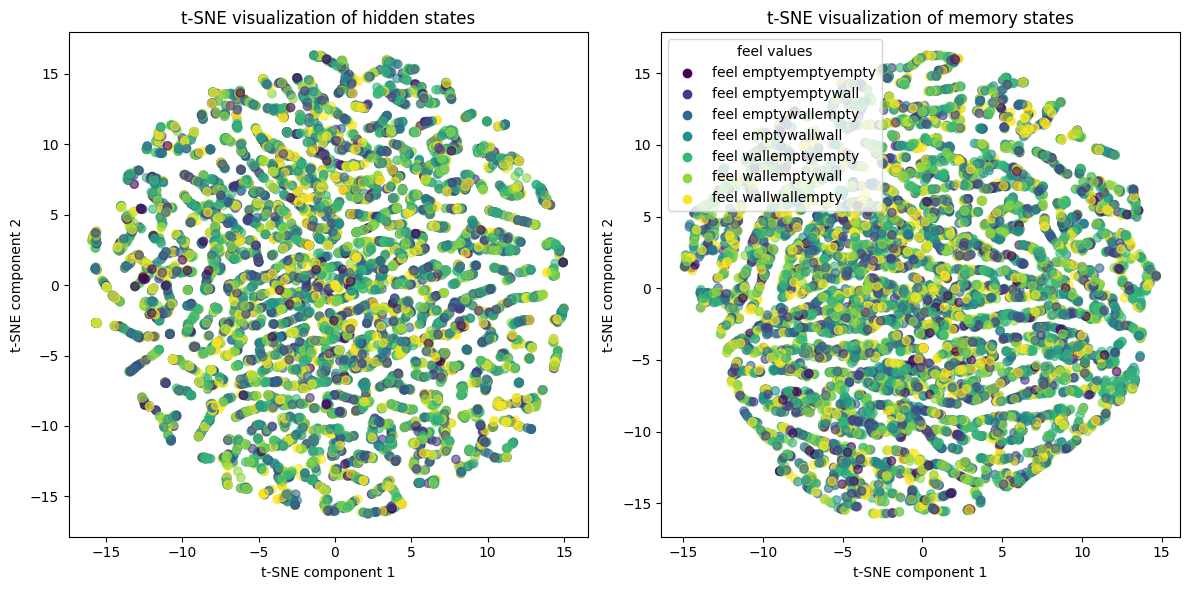

all_output_stack (10000, 512)


/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_output_emb (10000, 2)


/tmp/ipykernel_15801/3383366682.py:50: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)


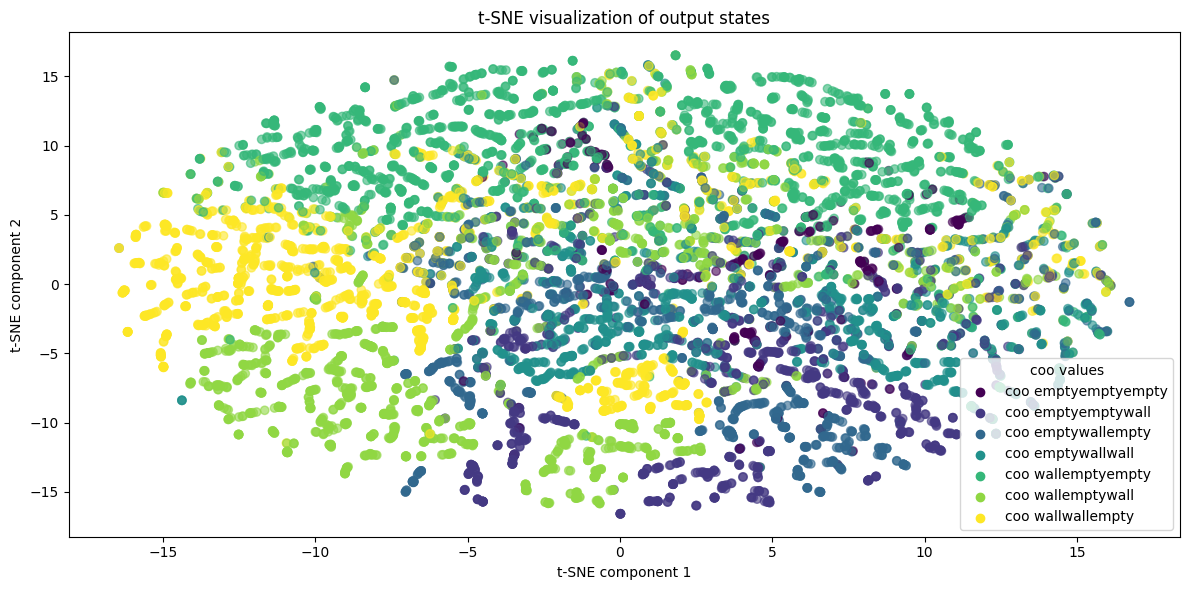

all_output_stack (10000, 512)


/home/pe/Documents/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_output_emb (10000, 2)


/tmp/ipykernel_15801/3383366682.py:70: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)


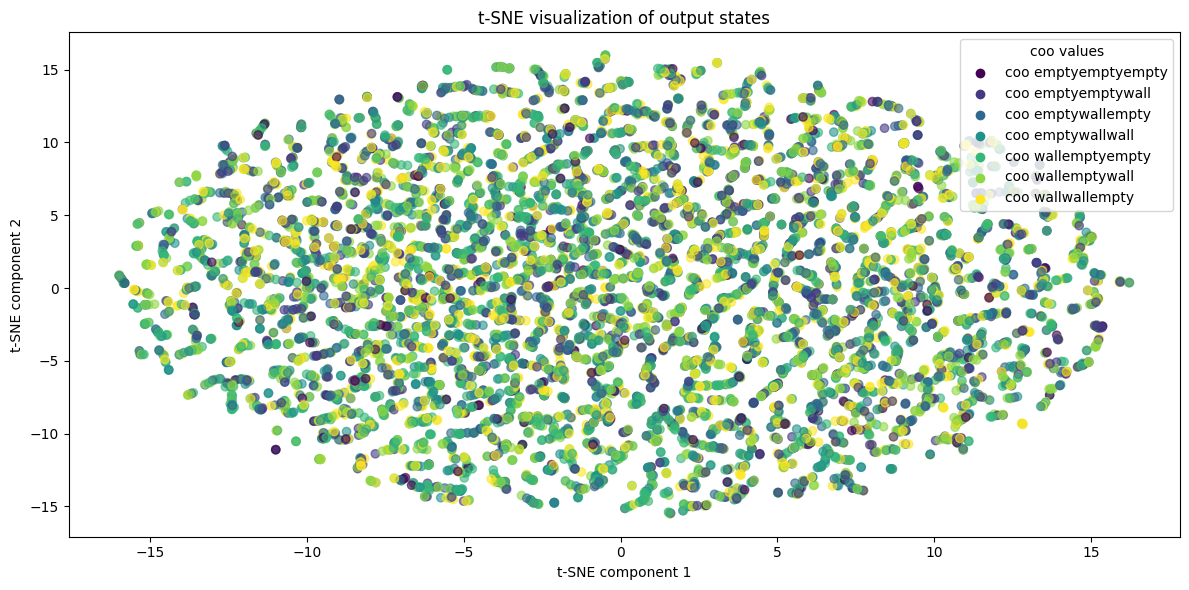

In [35]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)
print("all_hidden_emb", all_hidden_emb.shape)
print("all_mem_emb", all_mem_emb.shape)

feel_info = [str(info['feel_front']) + str(info['feel_left']) + str(info['feel_right']) for info in data_infos]

print("feel_info", feel_info)
unique_feel = np.unique(feel_info)
print("unique_feel", unique_feel)
color_map = plt.cm.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]
plt.figure(figsize=(12, 6))
# Plot pour all_hidden_emb
plt.subplot(1, 2, 1)
plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of hidden states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Plot pour all_mem_emb
plt.subplot(1, 2, 2)
plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of memory states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'feel {feel}')
plt.legend(title='feel values')
plt.tight_layout()
plt.show()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_1)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')
plt.tight_layout()
plt.show()


tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_2)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')
plt.tight_layout()
plt.show()


In [ ]:
input_seq = torch.tensor(tokenizer.encode(
    ['forward', 'empty', 'feel_right', 'empty', 'turn_left', 'empty', 'feel_front', 'empty', 'feel_front', 'empty', 'forward', 'empty', 'feel_left', 'empty', 'feel_front', 'wall', 'feel_left', 'empty', 'feel_left', 'empty', 'feel_left', 'empty', 'feel_front', 'wall', 'forward', 'wall', 'turn_right', 'empty', 'turn_right', '<pad>']
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq = ['forward', 'empty'] * 4
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))
1000
# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq[-1] = 'wall'
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq[-2] = 'feel_front'
list_seq[-1] = 'wall'
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq = ['feel_left', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty']
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


# Avec interaction

In [ ]:
env_interaction = gridWorld(x= 1, y=1, mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
env_interaction.display_world()

In [ ]:
list_vocab = ['<pad>', '<Masked>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_oumem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')tcomes():
        list_vocab.append((act, fb))

list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))

for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)

tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)

In [ ]:
def get_data_interaction(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        data.append(tokenizer.encode((action, feedback)))
    return data

In [ ]:
data_train_inter = []
for i in range(10):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=5))
print("data_train_inter", data_train_inter)
for seq in data_train_inter:
    print(tokenizer_interaction.decode(seq))

In [ ]:
td = TokenDrop(0.5, pad_token=0, num_special=2)

data_target_inter = td(torch.tensor(data_train_inter))
print("data_target_inter", data_target_inter)

In [ ]:
data_set_interaction = CustomDataSet(data_train_inter)

In [ ]:
def train_inter(model: nn.Module, data_loader_train: DataLoader, nb_epoch: int, optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td = TokenDropOdd(pourcentTokenDrop, pad_token=0, num_special=2)

    model.train()
    list_acc = []
    list_loss = []
    for epoch in tqdm(range(nb_epoch), desc=f"Training ", unit="epoch"):
        acc_means = 0
        loss_means = 0
        
        for i, data in enumerate(data_loader_train):
            data_mask = td(data)
            bs = data.shape[0]

            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size)
                        
            proba, hidden, memory = model(data_mask, hidden, memory)
            proba = proba.transpose(1, 2)
            pred = proba.argmax(dim=1)
            pad_mask = (data_mask == 0)
            # print("data_mask", data_mask)
            # print("pad_mask", pad_mask)
            # print("pred", pred)
            # print("data", data)
            
            correct = (pred == data) & pad_mask
            # print("correct", correct)
            # print("pad_mask", pad_mask)
            acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
            acc_means += acc
        
            loss = loss_fn(proba, data) 
            loss_means += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        acc_means /= len(data_loader_train)
        loss_means /= len(data_loader_train)
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {epoch + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")

In [ ]:
env_interaction = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

list_vocab = ['<pad>', '<Masked>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_outcomes():
        list_vocab.append((act, fb))
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))    
tmp = create_dico_numerate_word(list_vocab)
tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)

data_train_inter = []
for i in range(500):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=5))
data_set_interaction = CustomDataSet(data_train_inter)
data_loader_interaction = DataLoader(data_set_interaction, batch_size=2, shuffle=True)

model_inter = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.25
)

optimizer_inter = optim.Adam(model_inter.parameters(), lr=0.001)
loss_fn_inter = nn.CrossEntropyLoss()

In [ ]:
# train_inter(
#     model=model_inter,
#     data_loader_train=data_loader_interaction,
#     nb_epoch=100,
#     optimizer=optimizer_inter,
#     loss_fn=loss_fn_inter,
#     pourcentTokenDrop=0.15
# )